First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  print(dest_filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

.\notMNIST_large.tar.gz
Found and verified .\notMNIST_large.tar.gz
.\notMNIST_small.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  print(root)
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large
.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


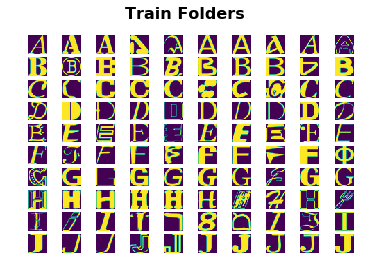

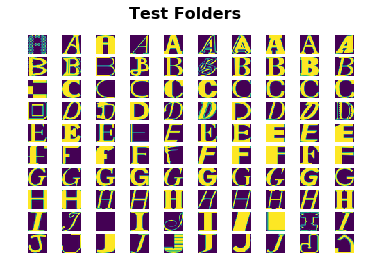

In [5]:
import random
import matplotlib.image as mpimg


def plot_samples(data_folders, sample_size, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    for folder in data_folders:
        image_files = os.listdir(folder)
        image_sample = random.sample(image_files, sample_size)
        for image in image_sample:
            image_file = os.path.join(folder, image)
            ax = fig.add_subplot(len(data_folders), sample_size, sample_size * data_folders.index(folder) +
                                 image_sample.index(image) + 1)
            image = mpimg.imread(image_file)
            ax.imshow(image)
            ax.set_axis_off()

    plt.show()
plot_samples(train_folders, 10, 'Train Folders')
plot_samples(test_folders, 10, 'Test Folders')

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [7]:
def load_and_display_pickle(datasets, sample_size, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    num_of_images = []
    for pickle_file in datasets:
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
            print('Total images in', pickle_file, ':', len(data))

            for index, image in enumerate(data):
                if index == sample_size: break
                ax = fig.add_subplot(len(datasets), sample_size, sample_size * datasets.index(pickle_file) +
                                     index + 1)
                ax.imshow(image)
                ax.set_axis_off()
                ax.imshow(image)

            num_of_images.append(len(data))

    balance_check(num_of_images)
    plt.show()
    return num_of_images

Total images in .\notMNIST_small\A.pickle : 1872
Total images in .\notMNIST_small\B.pickle : 1873
Total images in .\notMNIST_small\C.pickle : 1873
Total images in .\notMNIST_small\D.pickle : 1873
Total images in .\notMNIST_small\E.pickle : 1873
Total images in .\notMNIST_small\F.pickle : 1872
Total images in .\notMNIST_small\G.pickle : 1872
Total images in .\notMNIST_small\H.pickle : 1872
Total images in .\notMNIST_small\I.pickle : 1872
Total images in .\notMNIST_small\J.pickle : 1872
mean of # images : 1872.4
Well balanced 1872
Well balanced 1873
Well balanced 1873
Well balanced 1873
Well balanced 1873
Well balanced 1872
Well balanced 1872
Well balanced 1872
Well balanced 1872
Well balanced 1872


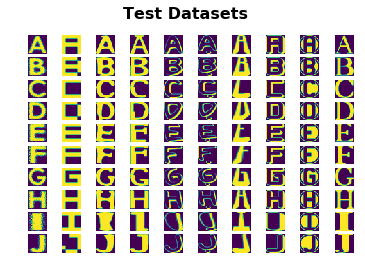

Total images in .\notMNIST_large\A.pickle : 52909
Total images in .\notMNIST_large\B.pickle : 52911
Total images in .\notMNIST_large\C.pickle : 52912
Total images in .\notMNIST_large\D.pickle : 52911
Total images in .\notMNIST_large\E.pickle : 52912
Total images in .\notMNIST_large\F.pickle : 52912
Total images in .\notMNIST_large\G.pickle : 52912
Total images in .\notMNIST_large\H.pickle : 52912
Total images in .\notMNIST_large\I.pickle : 52912
Total images in .\notMNIST_large\J.pickle : 52911
mean of # images : 52911.4
Well balanced 52909
Well balanced 52911
Well balanced 52912
Well balanced 52911
Well balanced 52912
Well balanced 52912
Well balanced 52912
Well balanced 52912
Well balanced 52912
Well balanced 52911


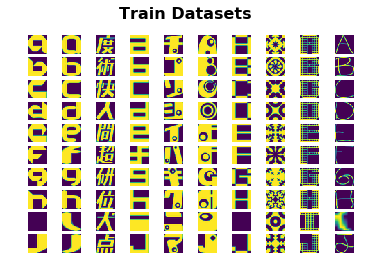

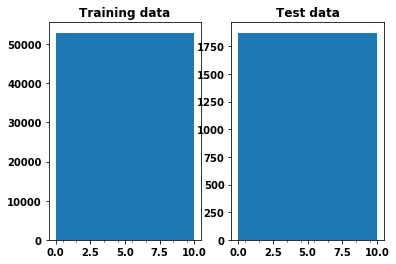

In [8]:
def generate_fake_label(sizes):
    labels = np.ndarray(sum(sizes), dtype=np.int32)
    start = 0
    end = 0
    for label, size in enumerate(sizes):
        start = end
        end += size
        for j in range(start, end):
            labels[j] = label
    return labels


def plot_balance():
    fig, ax = plt.subplots(1, 2)
    bins = np.arange(train_labels.min(), train_labels.max() + 2)
    ax[0].hist(train_labels, bins=bins)
    ax[0].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[0].set_title("Training data")

    bins = np.arange(test_labels.min(), test_labels.max() + 2)
    ax[1].hist(test_labels, bins=bins)
    ax[1].set_xticks((bins[:-1] + bins[1:]) / 2, [chr(k) for k in range(ord("A"), ord("J") + 1)])
    ax[1].set_title("Test data")
    plt.show()


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def balance_check(sizes):
    mean_val = mean(sizes)
    print('mean of # images :', mean_val)
    for i in sizes:
        if abs(i - mean_val) > 0.1 * mean_val:
            print("Too much or less images")
        else:
            print("Well balanced", i)

test_labels = generate_fake_label(load_and_display_pickle(test_datasets, 10, 'Test Datasets'))
train_labels = generate_fake_label(load_and_display_pickle(train_datasets, 10, 'Train Datasets'))

plot_balance()

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):#在merge_dagasets方法中把数据转换成图片个数*imgsize*imgsize(28)，同时建一个标签向量，大小为nb_rows
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):#将分布在10个pickle文件中的数据合并成一个张量     
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # 将读取到的pickle文件中的数据打乱
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


---
Problem 4
---------
Convince yourself that the data is still good after shuffling!
---

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

随后将数据随机排列，并保存

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

pickle_file = 'notMNIST.pickle'
try:
  f = open(pickle_file, 'wb')
  save = {#存到一个dictionary中去
    'train_dataset': train_dataset,#num*28*28
    'train_labels': train_labels,#num*10
    'valid_dataset': valid_dataset,#…
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)
Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

去除数据集中重复数据

In [11]:
import time

def check_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    start = time.process_time()
#     start = time.clock()
#     hash1 = set([hash(image1.data) for image1 in images1])
#     hash2 = set([hash(image2.data) for image2 in images2])
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.process_time()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))

Number of overlaps between training and test sets: 1153. Execution time: 0.53125.
Number of overlaps between training and validation sets: 953. Execution time: 0.53125.
Number of overlaps between validation and test sets: 55. Execution time: 0.046875.


In [12]:
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [13]:
# LogisticRegression

In [14]:
train_dataset_L = train_dataset
train_labels_L = train_labels
test_dataset_L = test_dataset
test_labels_L = test_labels
valid_dataset_L = valid_dataset
valid_labels_L =  valid_labels

In [98]:
# train_dataset = train_dataset_L
# train_labels = train_labels_L
# test_dataset = test_dataset_L
# test_labels = test_labels_L
# valid_dataset = valid_dataset_L
# valid_labels = valid_labels_L

In [ ]:
samples, width, height = train_dataset.shape
X_train = np.reshape(train_dataset_L,(samples,width*height))
y_train = train_labels_L

# Prepare testing data
samples, width, height = test_dataset.shape
X_test = np.reshape(test_dataset_L,(samples,width*height))
y_test = test_labels_L

# Import
from sklearn.linear_model import LogisticRegression

# Instantiate
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, verbose=1, max_iter=1000, n_jobs=-1)

# Fit
lg.fit(X_train, y_train)

# Predict
y_pred = lg.predict(X_test)

# Score
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

# 构建神经网络：

Finally, let's save the data for later reuse:
上面是一些预操作，然后我们读取这个pickle文件，得到卷积神经网络要使用的数据文件：

可见训练集、验证集和测试集的原始格式。如果要将数据用到一个人工神经网络中，就要把每个图像数据都转换成一个长×宽维的向量，而在卷积神经网络中我们需要将图片数据转换成长×宽×深度的样子，同时将labels转换成one-hot encodings格式，于是：

In [44]:
#下一步我们先定义一个用来检测预测精度的方法：
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])#注意这里的argmax方法返回的是数组的索引值。

前边说过了，tensorflow中进行运算，首先需要构建一个运算图，在这里将建立一个拥有两个卷积层和一个全连接层的卷积神经网络，算这个东西需要很土豪的显卡，所以限制了一下深度和全卷积层的节点。

单层

In [72]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale，如果要使用RGB格式数据就是3了
def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
#   Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)

  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


#tf.placeholder()

In [71]:
import tensorflow as tf
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
#   Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))

  biases = tf.Variable(tf.zeros([num_labels]))
  
    
    
  #model
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
#   optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)#SGD

   optimizer = tf.train.AdamOptimizer(0.1, epsilon=1e-08).minimize(loss)#默认的learning_rate=0.001，ADAM
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [72]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
#   init = tf.global_variables_initializer()
#   session.run(init)
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.202394
Minibatch accuracy: 7.0%
Validation accuracy: 12.5%
Minibatch loss at step 500: 1.825212
Minibatch accuracy: 71.9%
Validation accuracy: 75.3%
Minibatch loss at step 1000: 1.059290
Minibatch accuracy: 78.9%
Validation accuracy: 76.4%
Minibatch loss at step 1500: 1.270093
Minibatch accuracy: 77.3%
Validation accuracy: 77.2%
Minibatch loss at step 2000: 0.900837
Minibatch accuracy: 76.6%
Validation accuracy: 77.3%
Minibatch loss at step 2500: 0.819490
Minibatch accuracy: 82.8%
Validation accuracy: 78.0%
Minibatch loss at step 3000: 1.068629
Minibatch accuracy: 78.9%
Validation accuracy: 78.4%
Test accuracy: 85.9%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [1]:
#多层

In [99]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale，如果要使用RGB格式数据就是3了

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
#-1表示我懒得计算该填什么数字，由python通过a和其他的值3推测出来(这句话来自知乎，感觉好精辟啊)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32) 
#这句写的很迷，肿么解释。。。
#labels[:,None]相当于把shape为(20w,)的labels转换成shape为(20w,1)的数组，从[1,2,3,4...]到[[1],[2],[3],…]
#np.arange是生成了一个[0,1,2,3...]的(10,)的数组
#判断一个(10,)是否等于一个(10,1)的数组，或者说判断一个列向量是否等于一个行向量，可理解为矩阵乘法了，定义乘法规则为一样就是true，不一样就是false，那么这个判断式的结果就是一个20w*10的数组。
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [117]:
import tensorflow as tf
beta = 0.01 # define the hyper-parameter, beta, for L2 regularization
batch_size = 16 #SGD每次选取的图片个数
patch_size = 5 #卷积窗口大小
depth = 16 #卷积深度，就是特征图的个数
num_hidden = 64 #全连接层隐层大小

graph = tf.Graph()

with graph.as_default():
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))#每次选出batch_size个图片参与运算
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset) 
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))#随机初始化第一卷积层权重参数，depth*num_channels张特征图，滑动窗口大小为5*5
    layer1_biases = tf.Variable(tf.zeros([depth]))#第一卷积层bias项初始化为0
    layer2_weights = tf.Variable(tf.truncated_normal(#随机初始化第二卷积层权重参数，depth*depth张特征图，滑动窗口5*5
      [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))#第二卷积层bias项初始化为0
    layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))#全连接层第一层，//4是因为后边定义模型的时候定义stride为2，
    #所以两次卷积后的数据就是7*7*16*16了？？？？？？？
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(#全连接层第二层，产生截断正态分布随机数
      [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    keep_prob = tf.placeholder("float")
  # Model.
    def model(data,keep_prob):
        print(data.shape)
        conv_1 = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')#卷积，这里1,2,2,1是stride，依次对应到data的格式中去
        #same padding是补0的那种padding模式，比较便于运算，所以基本上都用这种的。
        #pool
        relu_layer_1 = tf.nn.relu(conv_1 + layer1_biases)#relu层，激活函数
        conv_2 = tf.nn.conv2d(relu_layer_1, layer2_weights, [1, 2, 2, 1], padding='SAME')
        relu_layer_2 = tf.nn.relu(conv_2 + layer2_biases)
        shape = relu_layer_2.get_shape().as_list()
        reshape = tf.reshape(relu_layer_2, [shape[0], shape[1] * shape[2] * shape[3]])

        relu_layer_3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        
#      Dropout on hidden layer: RELU layer
#         keep_prob = tf.placeholder("float")
        relu_layer_dropout = tf.nn.dropout(relu_layer_3, keep_prob)#全链接
        
        logits = tf.matmul(relu_layer_dropout, layer4_weights) + layer4_biases
        return logits

     # Training computation.
    logits = model(tf_train_dataset,keep_prob)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

    # Loss function with L2 Regularization with beta=0.01
    regularizers = tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights)#Regularization (正则化)
    loss = tf.reduce_mean(loss + beta * regularizers)

    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)#梯度下降

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset,keep_prob = 1))
    test_prediction = tf.nn.softmax(model(tf_test_dataset,keep_prob = 1))
    print(train_prediction)

(16, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
Tensor("Softmax:0", shape=(16, 10), dtype=float32)


使用session来计算。

In [118]:
num_steps = 30001
#batch_size=16
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()#for old version of tf0
#   session.run(tf.initialize_all_variables())
#     session.run(tf.global_variables_initializer())
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)#这句是防止迭代次数过多超出数据集范围，就通过取余数改变取batch的偏置
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob : 0.5}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
#       print(predictions)
#       print()
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print("Validation accuracy: {:.1f}".format(accuracy(valid_prediction.eval(), valid_labels)))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.849683
Minibatch accuracy: 6.2%
Validation accuracy: 12.7
Minibatch loss at step 500: 1.087010
Minibatch accuracy: 87.5%
Validation accuracy: 80.1
Minibatch loss at step 1000: 0.701646
Minibatch accuracy: 87.5%
Validation accuracy: 81.8
Minibatch loss at step 1500: 1.353922
Minibatch accuracy: 62.5%
Validation accuracy: 82.9
Minibatch loss at step 2000: 0.304058
Minibatch accuracy: 87.5%
Validation accuracy: 83.2
Minibatch loss at step 2500: 1.114041
Minibatch accuracy: 68.8%
Validation accuracy: 83.7
Minibatch loss at step 3000: 0.868032
Minibatch accuracy: 75.0%
Validation accuracy: 84.7
Minibatch loss at step 3500: 0.615300
Minibatch accuracy: 81.2%
Validation accuracy: 84.5
Minibatch loss at step 4000: 0.481677
Minibatch accuracy: 93.8%
Validation accuracy: 85.6
Minibatch loss at step 4500: 0.890283
Minibatch accuracy: 75.0%
Validation accuracy: 85.6
Minibatch loss at step 5000: 1.248181
Minibatch accuracy: 75.0%
Validation accuracy: 84.8
Min